In [ ]:
# Chess Pieces Classification

Importing packages

In [1]:
# Imports

# For displaying images
from IPython.display import Image 

# For plotting figures
import matplotlib.pyplot as plt
from matplotlib import gridspec

# For array and matrix data structures
import numpy as np

# For data manipulation and analysis
import pandas as pd

# For the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# For computing the neural network and preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

# Set Matplotlib defaults such that plots are bigger and labels are more clear
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

Loading in the data

In [2]:
# Load in the training data
ds_train = image_dataset_from_directory(
    'C:/Users/Jakub/Desktop/chess_cnn_dataset/train',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Load in the validation data
ds_valid = image_dataset_from_directory(
    'C:/Users/Jakub/Desktop/chess_cnn_dataset/valid',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Load in the test data
ds_test = image_dataset_from_directory(
    'C:/Users/Jakub/Desktop/chess_cnn_dataset/test',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

Found 1936 files belonging to 13 classes.
Found 236 files belonging to 13 classes.
Found 234 files belonging to 13 classes.


 Converting Images to floats

In [3]:
# Converting tf.uint8 to type float to normalize the images
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalize images from the training data
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the validation data
ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# normalize images from the test data
ds_test = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [4]:
# function which gets the labels of our dataset
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset))           # Get labels 
    if not batched:
        return tf.concat(labels, axis=0)                    # concat the list of batched labels
    return labels

# counts of the training data
array_train = get_labels_from_tfdataset(ds_train)
# getting the true labels
y_true_train = np.argmax(array_train,axis=1)
unique,counts= np.unique(y_true_train, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_train = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the validation data
array_valid = get_labels_from_tfdataset(ds_valid)
# getting the true labels
y_true_valid = np.argmax(array_valid,axis=1)
unique,counts= np.unique(y_true_valid, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_test = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# counts of the test data
array_test = get_labels_from_tfdataset(ds_test)
# getting the true labels
y_true_test = np.argmax(array_test,axis=1)
unique,counts= np.unique(y_true_test, return_counts = True)
unique = ['Bishop', 'King', "Knight", "Pawn", "Queen", "Rook", "Empty", "Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]
color = ['Black', 'Black', "Black", "Black", "Black", "Black", "None", "White", "White", "White", "White", "White", "White"]
np.asarray((unique,counts)).T
frequency_table_valid = pd.DataFrame(data=np.asarray((color,unique,counts)).T, columns=["color",'figure','count'])

# table of all counts
pd.concat([frequency_table_train, frequency_table_test["count"], frequency_table_valid["count"]], keys=['Train', 'Test', 'Valid'], axis=1)

Train                Test Valid
    color  figure count count count
0   Black  Bishop   160    20    20
1   Black    King    83    10    10
2   Black  Knight   137    17    17
3   Black    Pawn   156    19    19
4   Black   Queen   149    18    18
5   Black    Rook   160    20    18
6    None   Empty   170    21    21
7   White  Bishop   173    21    21
8   White    King    88    11    11
9   White  Knight   165    20    20
10  White    Pawn   161    19    19
11  White   Queen   160    19    19
12  White    Rook   174    21    21

Model (based on VGG16)

In [5]:
pretrained_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
pretrained_base.summary()
pretrained_base.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
model = tf.keras.Sequential([
       
    # DATA AUGMENTATION
    preprocessing.RandomContrast(factor=0.5), # lighter/darker colors
    preprocessing.RandomFlip(mode='horizontal'), # left-to-right
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1), # height decreased
        
    # BASE
    pretrained_base,
    # HEAD
    # Block 1
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    # Block 2 
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dropout(0.4),
    # Output
    layers.BatchNormalization(renorm=True),
    layers.Dense(13, activation='softmax'),
])

# Specifying when the model should stop its training process
early_stopping = EarlyStopping(
    min_delta = 0.001,           # minimium amount of change to count as an improvement
    patience = 5,
    restore_best_weights = True, # restore the weights to model with the lowest validation loss
)

# Specifing the Adam optimizer as our optimizer function
optimizer = tf.keras.optimizers.Adam(epsilon=0.001)

# Model compilation
model.compile(
    optimizer= optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [7]:
# Training the model
history = model.fit(
    ds_train,
    validation_data= ds_valid,
    #epochs= 200,
    epochs = 50,
    callbacks=[early_stopping],
   )

Epoch 1/50
61/61 [==============================] - 174s 3s/step - loss: 2.4880 - categorical_accuracy: 0.2211 - val_loss: 1.5229 - val_categorical_accuracy: 0.5212
Epoch 2/50
61/61 [==============================] - 177s 3s/step - loss: 1.4609 - categorical_accuracy: 0.5088 - val_loss: 0.8104 - val_categorical_accuracy: 0.7076
Epoch 3/50
61/61 [==============================] - 178s 3s/step - loss: 1.0834 - categorical_accuracy: 0.6570 - val_loss: 0.5773 - val_categorical_accuracy: 0.8008
Epoch 4/50
61/61 [==============================] - 176s 3s/step - loss: 0.8468 - categorical_accuracy: 0.7350 - val_loss: 0.4828 - val_categorical_accuracy: 0.8263
Epoch 5/50
61/61 [==============================] - 176s 3s/step - loss: 0.7180 - categorical_accuracy: 0.7820 - val_loss: 0.4006 - val_categorical_accuracy: 0.8729
Epoch 6/50
61/61 [==============================] - 177s 3s/step - loss: 0.6561 - categorical_accuracy: 0.8058 - val_loss: 0.3202 - val_categorical_accuracy: 0.9068
Epoch 7/50

Plots

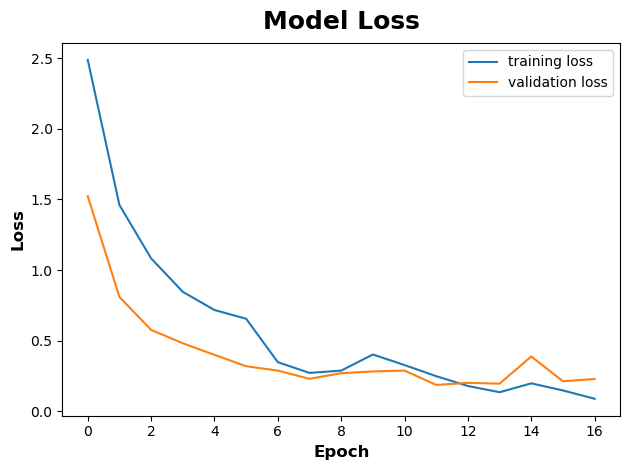

In [8]:
# Make a pandas dataframe so plots can be made from the model
history_frame = pd.DataFrame(history.history)

# Loss curve
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'])
plt.show()

# Accuracy curve
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

In [11]:
# metrics of the model
model.save('model2.h5')
history_frame[history_frame.val_loss == history_frame.val_loss.min()]

loss  categorical_accuracy  val_loss  val_categorical_accuracy
11  0.249819              0.922521  0.188022                  0.957627

61/61 [==============================] - 153s 3s/step
['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'emp = Empty', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']


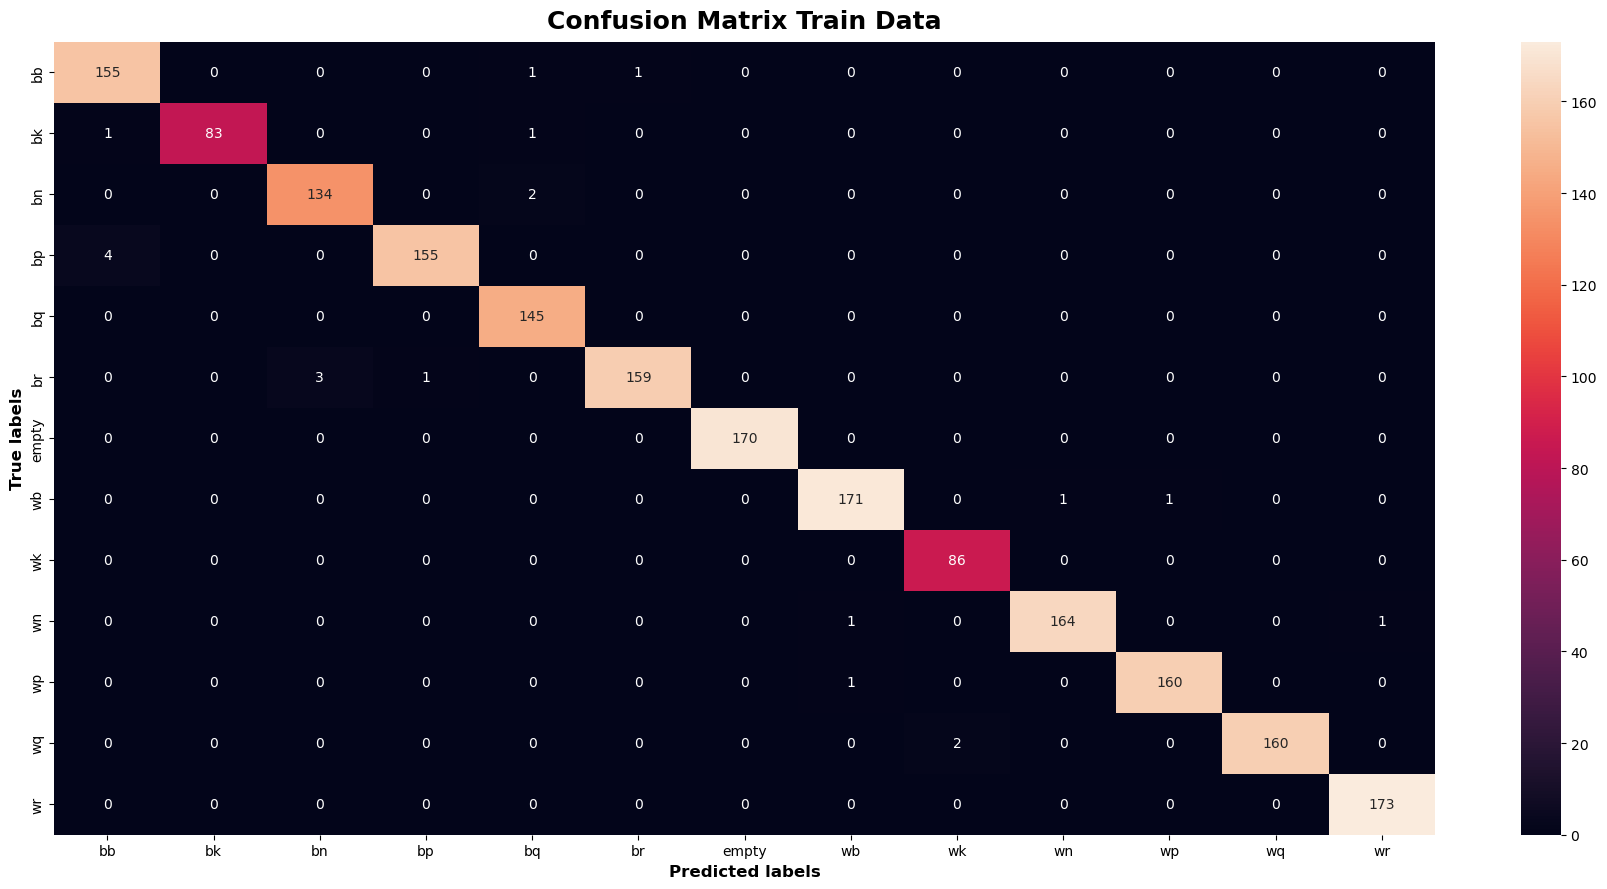

In [10]:
# Get the labels from the training data
array_train = get_labels_from_tfdataset(ds_train)
# Get the class probabilities from the model prediction on the training data
y_pred_train_prob = model.predict(ds_train)
# Use the class probabilities from the model prediction to get class predictions
y_pred_train = np.argmax(y_pred_train_prob,axis=1)

# Get the true values of the training data
y_true_train = np.argmax(array_train,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm_train = confusion_matrix(y_pred_train, y_true_train)

# now we plot the confusion matrix for the training data
plt.figure(figsize=(18,9))
ax_train = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax_train);  

# labels, title and ticks
ax_train.set_xlabel('Predicted labels');
ax_train.set_ylabel('True labels'); 
ax_train.set_title('Confusion Matrix Train Data');
ax_train.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_train.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);

# This serves as a legend which is too big for the plot
print(['bb = black Bishop', 'bk = black King', "bn = black Knight",
                "bp = black Pawn", "bq = black Queen", "br = black Rook",
                "emp = Empty", "wb = white Bishop", "wk = white King",
                "wn = white Knight","wp = white Pawn", "wq = white Queen",
                "wr = white Rook"])

In [19]:
# Get the labels from the test data
array_test = get_labels_from_tfdataset(ds_test)
# Get the class probabilities from the model prediction on the test data
y_pred_test_prob = model.predict(ds_test)
# Use the class probabilities from the model prediction to get class predictions
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Get the true values of the training data
y_true_test = np.argmax(array_test,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm_test = confusion_matrix(y_pred_test, y_true_test)

# now we plot the confusion matrix for the test data
plt.figure(figsize=(18,9))
ax_test = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax_test);

# labels, title and ticks
ax_test.set_xlabel('Predicted labels');
ax_test.set_ylabel('True labels'); 
ax_test.set_title('Confusion Matrix Test Data');
ax_test.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "emp", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_test.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "emp", "wb", "wk", "wn", "wp", "wq", "wr"]);


# This serves as a legend which is too big for the plot
print(['bb = black Bishop', 'bk = black King', "bn = black Knight",
                "bp = black Pawn", "bq = black Queen", "br = black Rook",
                "emp = Empty", "wb = white Bishop", "wk = white King",
                "wn = white Knight","wp = white Pawn", "wq = white Queen",
                "wr = white Rook"])

8/8 [==============================] - 17s 2s/step
['bb = black Bishop', 'bk = black King', 'bn = black Knight', 'bp = black Pawn', 'bq = black Queen', 'br = black Rook', 'emp = Empty', 'wb = white Bishop', 'wk = white King', 'wn = white Knight', 'wp = white Pawn', 'wq = white Queen', 'wr = white Rook']


In [20]:
# Creating a list of all the possible classes
target_names = ['black Bishop', 'black King', "black Knight",
                "black Pawn", "black Queen", "black Rook",
                "Empty", " white Bishop", "white King",
                "white Knight","white Pawn", "white Queen",
                "white Rook"]

# Making a classifcation report on the test data
print(classification_report(y_pred_test, y_true_test, target_names = target_names, digits = 4))
# Printing the overall accuracy of the model on the test data
print("total accuracy",accuracy_score(y_pred_test, y_true_test))

               precision    recall  f1-score   support

 black Bishop     0.9500    1.0000    0.9744        19
   black King     1.0000    0.7692    0.8696        13
 black Knight     1.0000    0.9444    0.9714        18
   black Pawn     1.0000    1.0000    1.0000        19
  black Queen     0.8889    1.0000    0.9412        16
   black Rook     0.9444    1.0000    0.9714        17
        Empty     1.0000    1.0000    1.0000        21
 white Bishop     0.9524    0.9091    0.9302        22
   white King     0.8182    0.9000    0.8571        10
 white Knight     1.0000    0.8333    0.9091        24
   white Pawn     0.7895    1.0000    0.8824        15
  white Queen     0.9474    0.8571    0.9000        21
   white Rook     0.9048    1.0000    0.9500        19

     accuracy                         0.9402       234
    macro avg     0.9381    0.9395    0.9351       234
 weighted avg     0.9461    0.9402    0.9398       234

total accuracy 0.9401709401709402


In [12]:
# Load in the application data
ds_application = image_dataset_from_directory(
   'C:/Users/Jakub/Desktop/chess_cnn_dataset/Application_data',
    labels='inferred',         # same labels as map labels
    label_mode='categorical',  # categorical data
    image_size=[224, 224],
    interpolation='nearest',   # used for small image size
    batch_size=32,
    shuffle=True,              # classes are randomized
)

# Normalize images from the application data
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_application = (
    ds_application
   .map(convert_to_float)
   .cache()
   .prefetch(buffer_size=AUTOTUNE)
)

Found 144 files belonging to 13 classes.


SyntaxError: invalid syntax (4082440026.py, line 1)

In [14]:
# Get the labels from the application data
array_application = get_labels_from_tfdataset(ds_application)
# Get the class probabilities from the model prediction on the application data
y_pred_application_prob = model.predict(ds_application)
# Use the class probabilities from the model prediction to get class predictions
y_pred_application = np.argmax(y_pred_application_prob, axis=1)

# Get the true values of the application data
y_true_application = np.argmax(array_application,axis=1)

# Create a confusion matrix of the true classes compared to the predicted classes
cm = confusion_matrix(y_pred_application, y_true_application)

# Now we plot the confusion matrix for the application data
plt.figure(figsize=(15,7.5))
ax_application = plt.subplot()
# annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cm, annot=True, fmt='g', ax=ax_application);

# labels, title and ticks
ax_application.set_xlabel('Predicted labels');
ax_application.set_ylabel('True labels'); 
ax_application.set_title('Confusion Matrix Application Data');
ax_application.xaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);
ax_application.yaxis.set_ticklabels(['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]);

5/5 [==============================] - 10s 2s/step


In [15]:
# Creating a list of all the possible classes
target_names = ['bb', 'bk', "bn", "bp", "bq", "br", "empty", "wb", "wk", "wn", "wp", "wq", "wr"]
# Making a classifcation report on the application data
print(classification_report(y_pred_application, y_true_application, target_names=target_names, digits=4))

# Printing the overall accuracy of the model on the application data
print("total accuracy",accuracy_score(y_pred_application, y_true_application))

              precision    recall  f1-score   support

          bb     0.0000    0.0000    0.0000         2
          bk     0.0000    0.0000    0.0000         1
          bn     0.9000    0.4500    0.6000        20
          bp     0.2000    1.0000    0.3333         2
          bq     0.0000    0.0000    0.0000         0
          br     0.0000    0.0000    0.0000         0
       empty     0.5833    0.1795    0.2745        78
          wb     0.0000    0.0000    0.0000         5
          wk     0.0000    0.0000    0.0000         1
          wn     0.9000    0.5294    0.6667        17
          wp     0.4000    0.2500    0.3077        16
          wq     0.0000    0.0000    0.0000         2
          wr     0.0000    0.0000    0.0000         0

    accuracy                         0.2639       144
   macro avg     0.2295    0.1853    0.1679       144
weighted avg     0.5944    0.2639    0.3495       144

total accuracy 0.2638888888888889


C:\Users\Jakub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jakub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jakub\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
